# Reconstruct Positions with UMAP

In this notebook, we demonstrate how UMAP can be used to reconstruct positions at single cell resolution on the simulated data. We provide examples of reconstructions on a uniform grid and ground-truth positions from the Slide-seq kidney dataset as well for the two variations shown in the supplement - satellite dispersion through e.Coli colonies and anisotropic diffusion.

In [1]:
import anndata
import umap
import sys
import numpy as np
import sklearn
from matplotlib import pyplot as plt

sys.path.append("../functions/")
import alignment
import visuals

In [2]:
# Set parameters
SAMPLE = 'kidney_140rpb' # Read per bead distribution, cacluated from Slide-seq samples
SATELLIES = 10**5        # Satellites per cm2
SIGMA_UM = 50            # Width of the diffusion kernel
BEADWIDTH = 10

### Uniform Grid

In [3]:
# Load the data
adata = anndata.read_h5ad('../data/adata/{}_satellites={}_sigma={}.h5ad'.format(SAMPLE, SATELLIES, SIGMA_UM))
n = np.sqrt(adata.shape[0])

First, we row-normalize the data so that cell $[i,j]$ represents the proportion of reads for bead $i$ that come from satellite $j$. This makes the read vectors similar for nearby beads that differed in bead quality. We then pass the normalized coordinates to UMAP, using the Euclidean distance and hyperparameters that were selected using a simple grid search. See the supplement for more information on hyperparameter selection. 

Instead of row-normalizing the data and using the Euclidean distance, you can try using the cosine similarity which only depends on the angle between the vectors. However, in experiments we found that normalizing and using the Euclidean distance resulted in marginally better reconstructions.

In [4]:
# Normalize the data and run UMAP
adata.X = sklearn.preprocessing.normalize(adata.X, norm='l1')
mapper = umap.UMAP(n_neighbors=60, metric='euclidean', random_state=0, n_epochs=2000, min_dist=0.75, unique=True, verbose=True)
coords = mapper.fit_transform(adata.X)

UMAP(min_dist=0.75, n_epochs=2000, n_neighbors=60, random_state=0, unique=True,
     verbose=True)


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Unique=True -> Number of data points reduced from  99856  to  99802
Most common duplicate is 63157  with a count of  3
Construct fuzzy simplicial set
Tue Aug 23 20:56:38 2022 Finding Nearest Neighbors
Tue Aug 23 20:56:38 2022 Building RP forest with 21 trees
Tue Aug 23 21:00:01 2022 metric NN descent for 17 iterations
	 0  /  17
	 1  /  17
Tue Aug 23 21:04:56 2022 Finished Nearest Neighbor Search
Tue Aug 23 21:05:01 2022 Construct embedding
	completed  0  /  2000 epochs
	completed  400  /  2000 epochs
	completed  600  /  2000 epochs
	completed  800  /  2000 epochs
	completed  1000  /  2000 epochs
	completed  1200  /  2000 epochs
	completed  1400  /  2000 epochs
	completed  1600  /  2000 epochs
	completed  1800  /  2000 epochs
Tue Aug 23 21:26:18 2022 Finished embedding


Since the sBC counts only give information about relative position, the embedding may be translated, shrunken, expanded, rotated, or flipped relative to the ground truth. To compare to the ground truth, we optimize for the best alignment of a simple linear transformation of the embedding. 

In [5]:
# Align the UMAP with the ground-truth using a simple linear transformation
ground_truth = np.array([adata.obs.x, adata.obs.y]).T
dist_gt, aligned_coords, transf = alignment.align(coords, ground_truth, rel_scale=1)
dist_gt = dist_gt*n*BEADWIDTH # Scale distance to ground truth to um

Finally, we can compare the reconstruction to the ground truth. First, we visualize the reconstruction showing the ground truth coordinates (left) and the reconstruction (center) on a colored background with radial lines and with beads colored by distance to the ground truth (left). Second, we visualize the complementary cumulative distribution, or the proportion of beads with a reconstruction distance beyond a given distance with dashed lines indicating 50% and 90% of beads having a reconstruction distance below that value. For the example parameters, 50% of beads are within 19 $\mu m$ of the ground truth while 90% are within 40 $\mu m$.

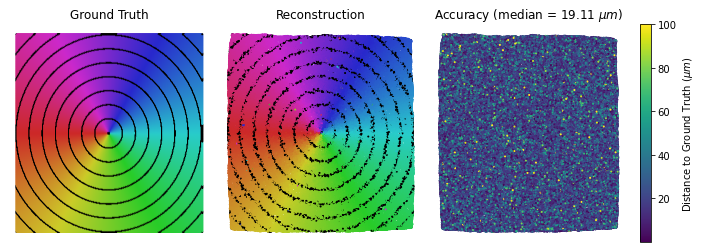

In [6]:
# Visually compare the reconstruction to the ground truth
visuals.ground_truth_comparison(adata, aligned_coords, dist_gt)

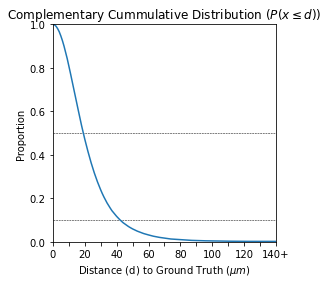

In [7]:
# Plot the complementary cummulative distribution
visuals.complementary_cummulative_distribution(dist_gt, max_dist=140)

### Slide-seq Kidney Positions

Here we repeat the reconstruction for the simulated data using ground-truth positions from the Slide-seq kidney sample.

In [8]:
# Load the data
adata = anndata.read_h5ad('../data/adata/{}_satellites={}_sigma={}_slideseq_kidney_positions.h5ad'.format(SAMPLE, SATELLIES, SIGMA_UM))
n = np.sqrt(adata.shape[0])

In [9]:
# Normalize the data and run UMAP
adata.X = sklearn.preprocessing.normalize(adata.X, norm='l1')
mapper = umap.UMAP(n_neighbors=60, metric='euclidean', random_state=0, n_epochs=2000, min_dist=0.75, unique=True, verbose=True)
coords = mapper.fit_transform(adata.X)

UMAP(min_dist=0.75, n_epochs=2000, n_neighbors=60, random_state=0, unique=True,
     verbose=True)


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Unique=True -> Number of data points reduced from  30758  to  30753
Most common duplicate is 3687  with a count of  2
Construct fuzzy simplicial set
Tue Aug 23 21:26:24 2022 Finding Nearest Neighbors
Tue Aug 23 21:26:24 2022 Building RP forest with 14 trees
Tue Aug 23 21:26:52 2022 metric NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
Tue Aug 23 21:28:18 2022 Finished Nearest Neighbor Search
Tue Aug 23 21:28:18 2022 Construct embedding
	completed  0  /  2000 epochs
	completed  200  /  2000 epochs
	completed  400  /  2000 epochs
	completed  600  /  2000 epochs
	completed  800  /  2000 epochs
	completed  1000  /  2000 epochs
	completed  1200  /  2000 epochs
	completed  1400  /  2000 epochs
	completed  1600  /  2000 epochs
	completed  1800  /  2000 epochs
Tue Aug 23 21:34:32 2022 Finished embedding


In [10]:
# Align the UMAP with the ground-truth using a simple linear transformation
ground_truth = np.array([adata.obs.x, adata.obs.y]).T
dist_gt, aligned_coords, transf = alignment.align(coords, ground_truth, rel_scale=1)
dist_gt = dist_gt*n*BEADWIDTH # Scale distance to ground truth to um

Again, we can compare the results visually and quantitatively. In this case, we see the reconstruction is slightly improved for the Slide-seq ground truth positions, achieving a meadian distance to the ground truth of 12 $\mu m$.

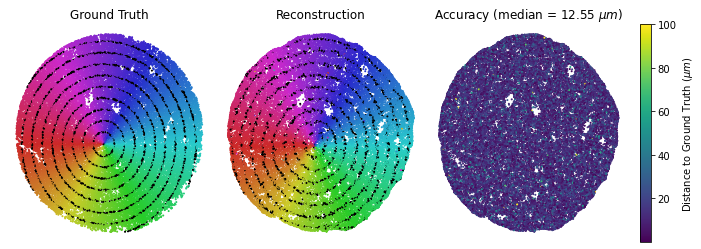

In [12]:
# Visually compare the reconstruction to the ground truth
visuals.ground_truth_comparison(adata, aligned_coords, dist_gt)

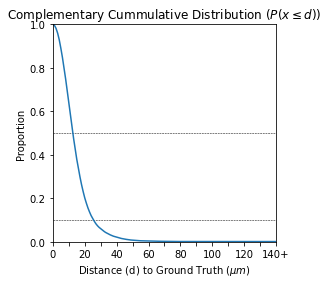

In [13]:
# Plot the complementary cummulative distribution
visuals.complementary_cummulative_distribution(dist_gt, max_dist=140)

## Supplemental Methods
Here we reproduce the reconstructions for two additional scenarios - using e.Coli colonies to disperse satellite barcodes and standard satellite dispersion with anisotropic diffusion. 

### Bacterial Colonies as Satellites

In [14]:
# Load the data
adata = anndata.read_h5ad('../data/adata/{}_satellites={}_sigma={}_irregular_colonies.h5ad'.format(SAMPLE, SATELLIES, SIGMA_UM))
n = np.sqrt(adata.shape[0])

In [ ]:
# Normalize the data and run UMAP
adata.X = sklearn.preprocessing.normalize(adata.X, norm='l1')
mapper = umap.UMAP(n_neighbors=60, metric='euclidean', random_state=0, n_epochs=2000, min_dist=0.75, unique=True, verbose=True)
coords = mapper.fit_transform(adata.X)

UMAP(min_dist=0.75, n_epochs=2000, n_neighbors=60, random_state=0, unique=True,
     verbose=True)


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


Unique=True -> Number of data points reduced from  99856  to  99786
Most common duplicate is 96149  with a count of  3
Construct fuzzy simplicial set
Wed Aug 24 05:22:19 2022 Finding Nearest Neighbors
Wed Aug 24 05:22:19 2022 Building RP forest with 21 trees
Wed Aug 24 05:25:36 2022 metric NN descent for 17 iterations
	 0  /  17
	 1  /  17
Wed Aug 24 05:29:52 2022 Finished Nearest Neighbor Search
Wed Aug 24 05:29:54 2022 Construct embedding
	completed  0  /  2000 epochs
	completed  200  /  2000 epochs
	completed  400  /  2000 epochs
	completed  600  /  2000 epochs


In [ ]:
# Align the UMAP with the ground-truth using a simple linear transformation
ground_truth = np.array([adata.obs.x, adata.obs.y]).T
dist_gt, aligned_coords, transf = alignment.align(coords, ground_truth, rel_scale=1)
dist_gt = dist_gt*n*BEADWIDTH # Scale distance to ground truth to um

In [ ]:
# Visually compare the reconstruction to the ground truth
visuals.ground_truth_comparison(adata, aligned_coords, dist_gt)

In [ ]:
# Plot the complementary cummulative distribution
visuals.complementary_cummulative_distribution(dist_gt, max_dist=140)